In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]

A search has been initiated within the folder named 'TB-DATASET'.
There are 1842 images in the health folder.
There are 988 images in the latent-tb folder.
There are 700 images in the Tuberculosis folder.
There are 901 images in the uncertain-tb folder.
The search has been completed.


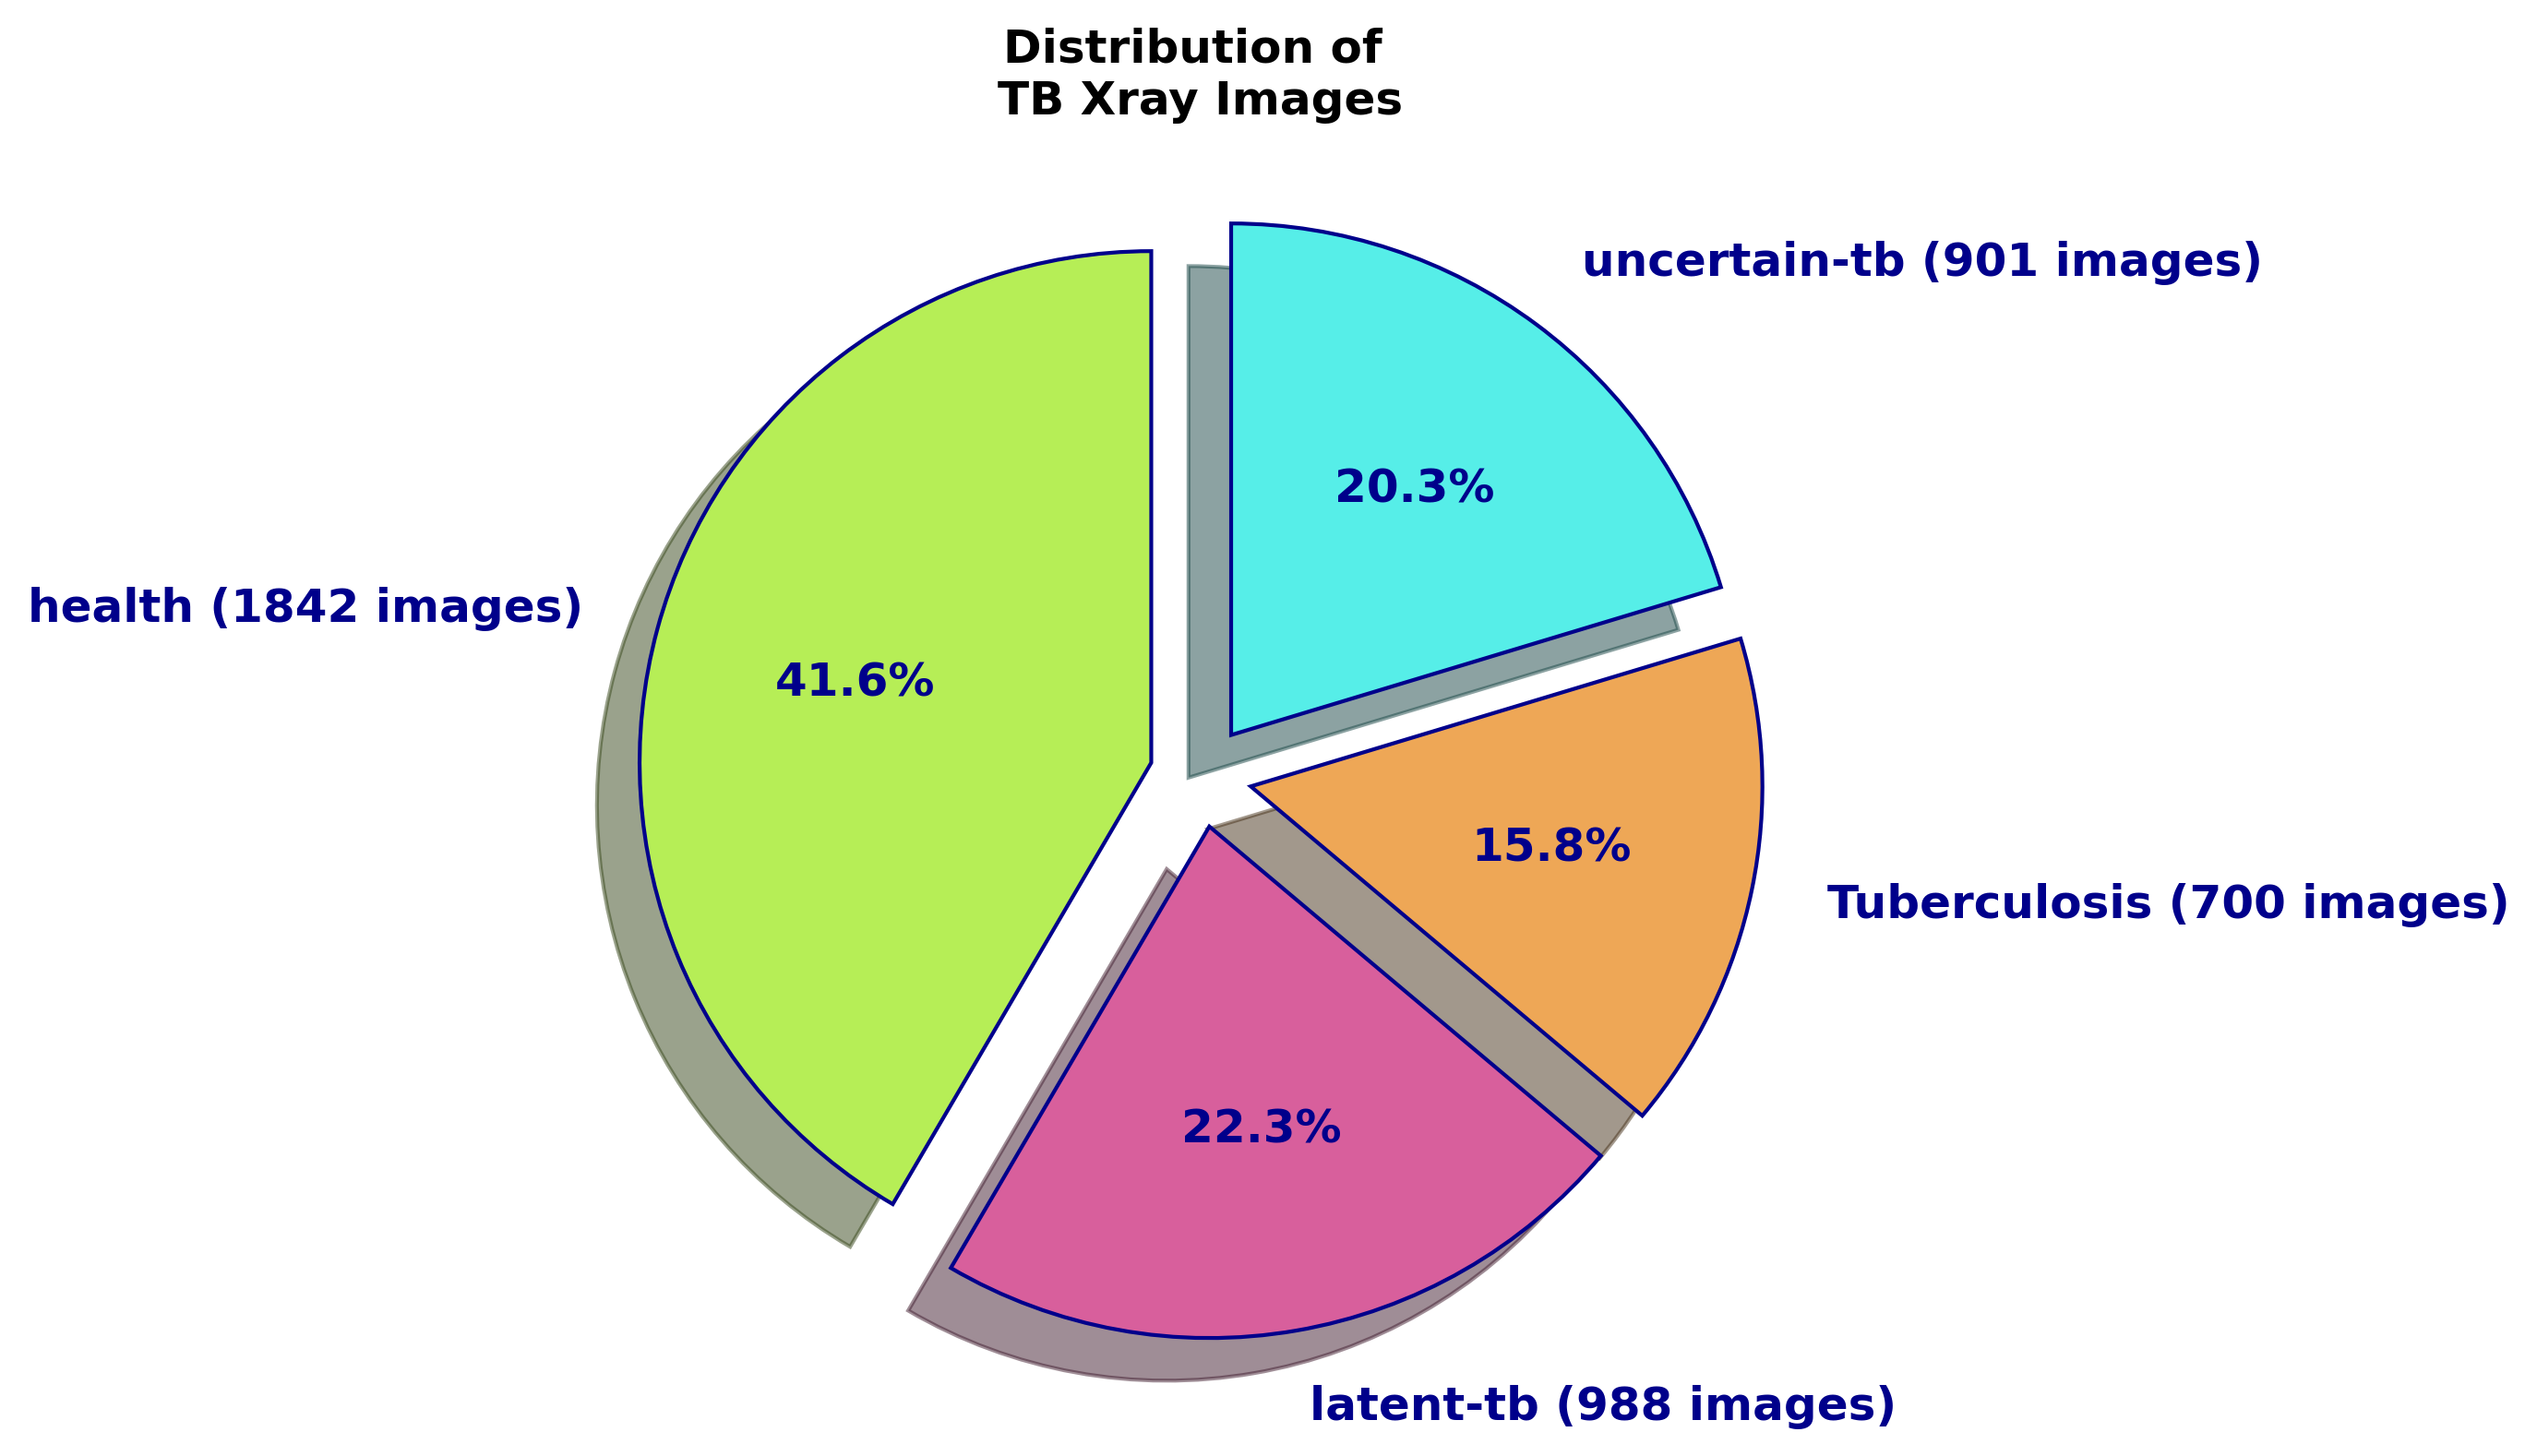

In [3]:
class_dist = {}
def image_counter(folder_path):
    basename = os.path.basename(folder_path)
    print('\033[92m'+f"A search has been initiated within the folder named '{basename}'."+'\033[0m')
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext in image_extensions:
                    count += 1
            
            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")
    print('\033[92m'+"The search has been completed."+'\033[0m')
    
    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,)*len(keys)
    
    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]
    
    plt.pie(values, explode=explode,labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors, textprops={'fontsize': 12, "fontweight" : "bold", "color":"darkblue"},  wedgeprops=
           {'edgecolor':'darkblue'} , labeldistance=1.15)
    plt.title("Distribution of \nTB Xray Images", size=12, fontweight="bold")

PATH = 'TB-DATASET'

image_counter(PATH)

In [6]:
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)

class_names = data.class_names

Found 4431 files belonging to 4 classes.


In [8]:
def sample_bringer(path, target, num_samples=5):
    class_path = os.path.join(path, target)
    image_files = [f for f in os.listdir(class_path) if f.endswith('.png')]

    # Check if num_samples is greater than the number of available images
    num_samples = min(num_samples, len(image_files))

    for i in range(num_samples):
        image_path = os.path.join(class_path, image_files[i])
        img = mpimg.imread(image_path)
        # Rest of your code for processing the image

class_names = ["Tuberculosis", "health", "latent-tb","uncertain-tb"]
for target in class_names:
    sample_bringer(PATH, target=target)

In [13]:
alz_dict = {index: img for index, img in enumerate(data.class_names)}

class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        text = "Min and max pixel values in the batch ->"
        print(text, self.batch[0].min(), "&", self.batch[0].max())
        
    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="gray")
        fig.suptitle("Chest Xray Samples in the Batch", color="yellow",fontsize=18, fontweight='bold', y=0.6)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(alz_dict[class_no], color="aqua")
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])
    
    def train_test_val_split(self, train_size, val_size, test_size):

        train = int(len(self.data)*train_size)
        test = int(len(self.data)*test_size)
        val = int(len(self.data)*val_size)
        
        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)
        test_data = self.data.skip(train+val).take(test)

        return train_data, val_data, test_data

Min and max pixel values in the batch -> 0.0 & 1.0


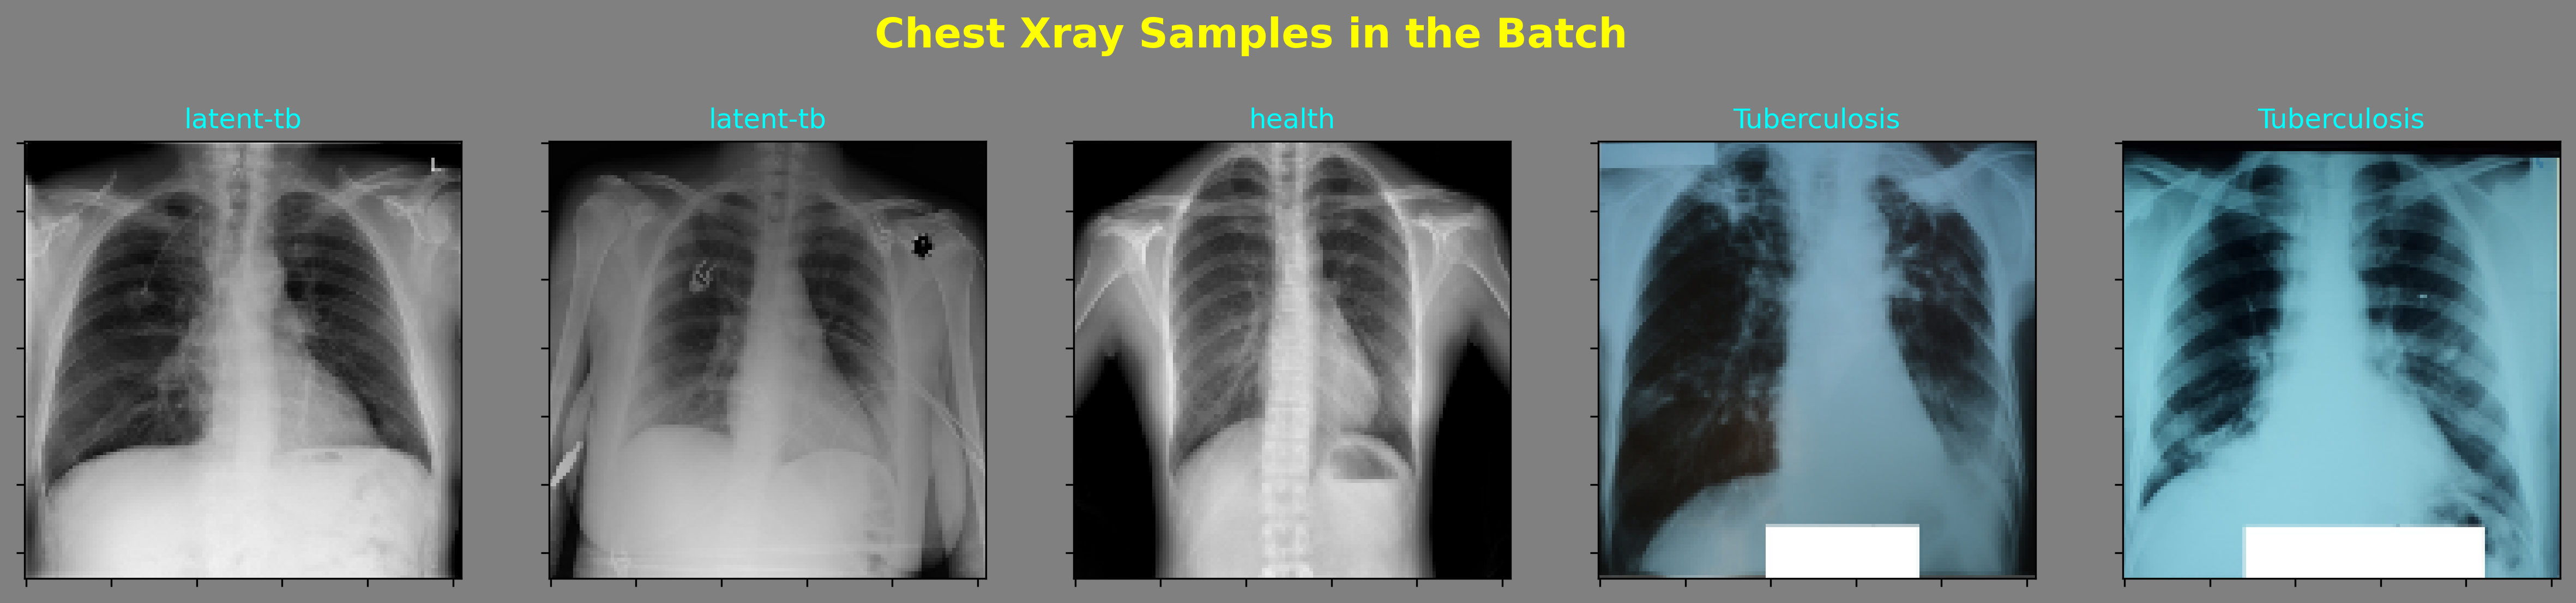

In [15]:
process = Process(data)
process.create_new_batch()
process.show_batch_images(number_of_images=5)

In [16]:
train_data, val_data, test_data= process.train_test_val_split(train_size=0.8, val_size=0.1, test_size=0.1)

In [17]:
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

In [18]:
def build_model():
    model = Sequential()
    
    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal',
                     input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation="relu", kernel_initializer='he_normal'))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(4, activation="softmax"))

    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    
    model.summary()
    
    return model

model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [21]:
def checkpoint_callback():
    
    checkpoint_filepath = '\\tmp\\checkpoint'
    
    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           frequency='epoch',
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    
    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback


EPOCHS = 20
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

In [22]:
history = model.fit(train_data, epochs = EPOCHS, validation_data = val_data, class_weight = class_weights, callbacks = callbacks)

Epoch 1/20
111/111 [==============================] - ETA: 0s - loss: 0.2945 - accuracy: 0.9119
Epoch 1: val_accuracy improved from -inf to 0.93510, saving model to \tmp\checkpoint
INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


111/111 [==============================] - 79s 704ms/step - loss: 0.2945 - accuracy: 0.9119 - val_loss: 0.2014 - val_accuracy: 0.9351
Epoch 2/20
111/111 [==============================] - ETA: 0s - loss: 0.1648 - accuracy: 0.9490
Epoch 2: val_accuracy improved from 0.93510 to 0.94471, saving model to \tmp\checkpoint
INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


111/111 [==============================] - 74s 657ms/step - loss: 0.1648 - accuracy: 0.9490 - val_loss: 0.1610 - val_accuracy: 0.9447
Epoch 3/20
111/111 [==============================] - ETA: 0s - loss: 0.1050 - accuracy: 0.9710
Epoch 3: val_accuracy improved from 0.94471 to 0.96394, saving model to \tmp\checkpoint
INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


111/111 [==============================] - 79s 704ms/step - loss: 0.1050 - accuracy: 0.9710 - val_loss: 0.1161 - val_accuracy: 0.9639
Epoch 4/20
111/111 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9800
Epoch 4: val_accuracy improved from 0.96394 to 0.96635, saving model to \tmp\checkpoint
INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


111/111 [==============================] - 73s 646ms/step - loss: 0.0629 - accuracy: 0.9800 - val_loss: 0.1165 - val_accuracy: 0.9663
Epoch 5/20
111/111 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9733
Epoch 5: val_accuracy did not improve from 0.96635
111/111 [==============================] - 79s 702ms/step - loss: 0.0734 - accuracy: 0.9733 - val_loss: 0.2048 - val_accuracy: 0.9519
Epoch 6/20
111/111 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.9935
Epoch 6: val_accuracy improved from 0.96635 to 0.96875, saving model to \tmp\checkpoint
INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


111/111 [==============================] - 96s 860ms/step - loss: 0.0254 - accuracy: 0.9935 - val_loss: 0.1300 - val_accuracy: 0.9688
Epoch 7/20
111/111 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9918
Epoch 7: val_accuracy did not improve from 0.96875
111/111 [==============================] - 82s 725ms/step - loss: 0.0269 - accuracy: 0.9918 - val_loss: 0.1129 - val_accuracy: 0.9639
Epoch 8/20
111/111 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.9865
Epoch 8: val_accuracy improved from 0.96875 to 0.97596, saving model to \tmp\checkpoint
INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


111/111 [==============================] - 89s 788ms/step - loss: 0.0410 - accuracy: 0.9865 - val_loss: 0.1073 - val_accuracy: 0.9760
Epoch 9/20
111/111 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9899
Epoch 9: val_accuracy did not improve from 0.97596
111/111 [==============================] - 88s 787ms/step - loss: 0.0338 - accuracy: 0.9899 - val_loss: 0.0945 - val_accuracy: 0.9663
Epoch 10/20
111/111 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9972
Epoch 10: val_accuracy did not improve from 0.97596
111/111 [==============================] - 85s 761ms/step - loss: 0.0099 - accuracy: 0.9972 - val_loss: 0.1080 - val_accuracy: 0.9688
Epoch 11/20
111/111 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9949
Epoch 11: val_accuracy improved from 0.97596 to 0.98317, saving model to \tmp\checkpoint
INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


111/111 [==============================] - 73s 652ms/step - loss: 0.0158 - accuracy: 0.9949 - val_loss: 0.0713 - val_accuracy: 0.9832
Epoch 12/20
111/111 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9975
Epoch 12: val_accuracy did not improve from 0.98317
111/111 [==============================] - 75s 668ms/step - loss: 0.0064 - accuracy: 0.9975 - val_loss: 0.0847 - val_accuracy: 0.9712
Epoch 13/20
111/111 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9958
Epoch 13: val_accuracy did not improve from 0.98317
111/111 [==============================] - 90s 807ms/step - loss: 0.0087 - accuracy: 0.9958 - val_loss: 0.1574 - val_accuracy: 0.9663
Epoch 14/20
111/111 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9975
Epoch 14: val_accuracy did not improve from 0.98317
111/111 [==============================] - 91s 803ms/step - loss: 0.0099 - accuracy: 0.9975 - val_loss: 0.1397 - val_accuracy: 0.9663
Epoch 15/20
111/1

In [24]:
model.evaluate(test_data)
model.save("model.h5")

13/13 [==============================] - 15s 150ms/step - loss: 0.2390 - accuracy: 0.9423


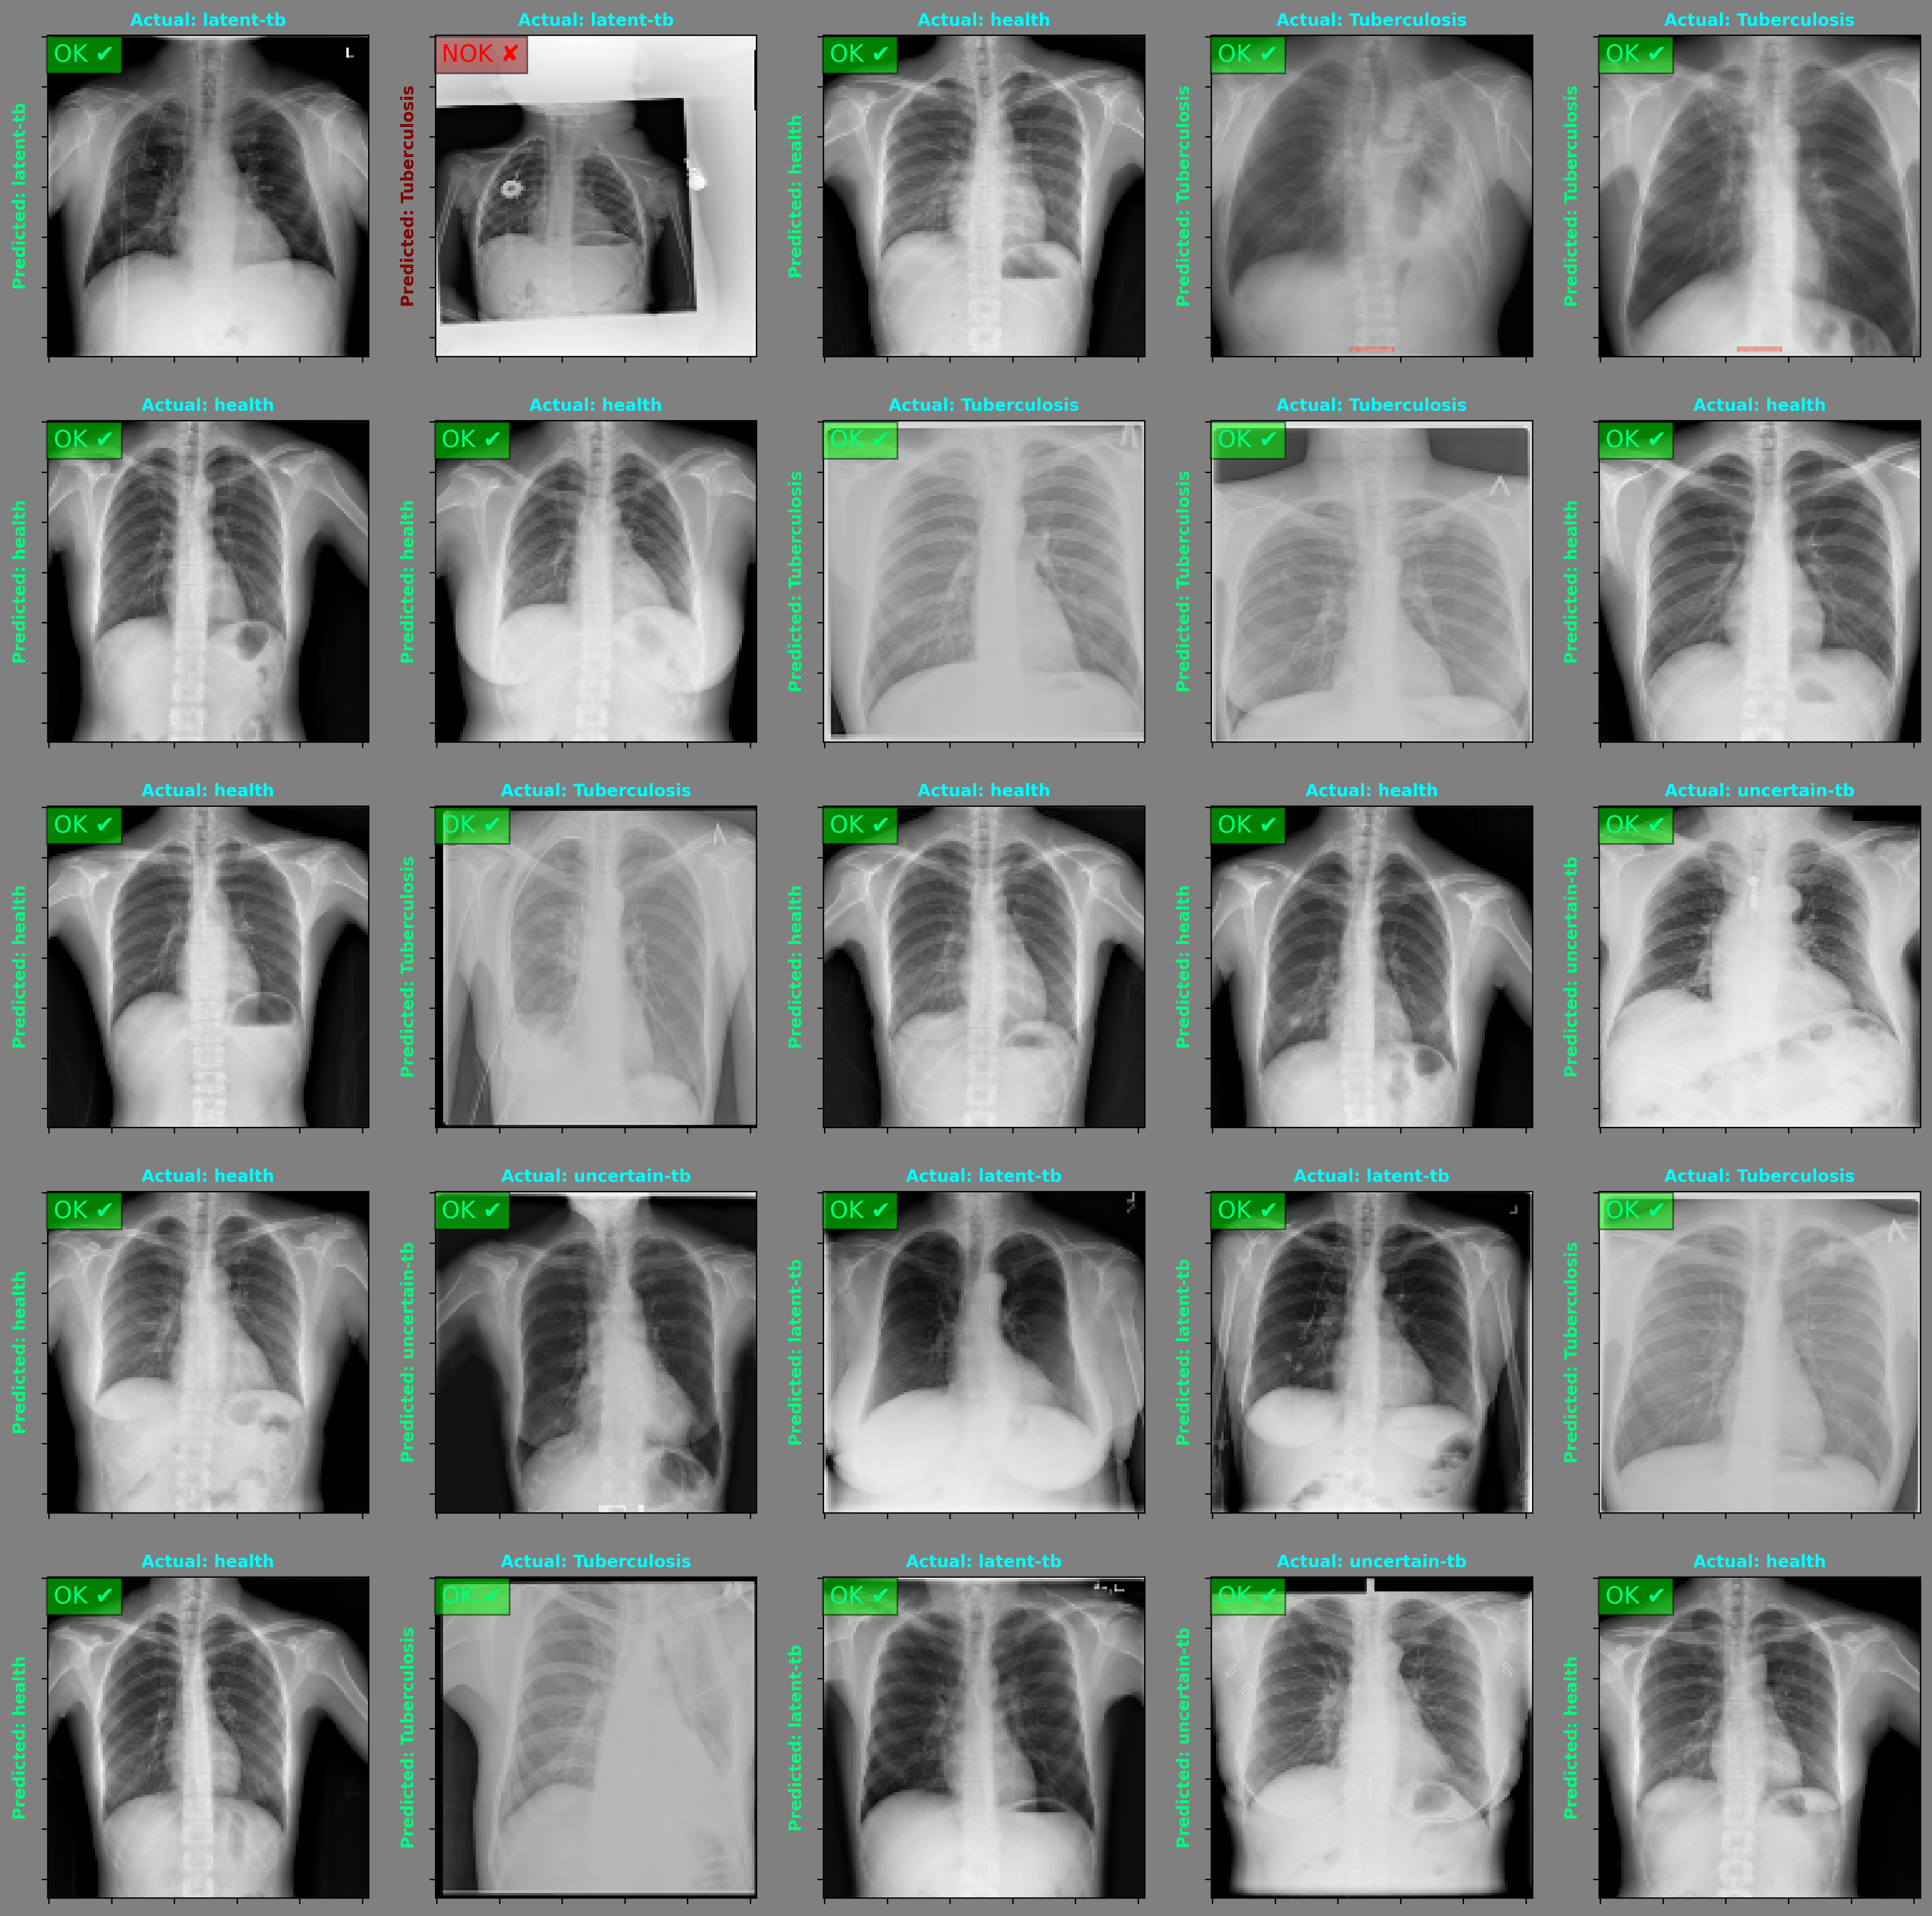

In [32]:
plt.figure(figsize=(20, 20), facecolor="gray")
for images, labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        predictions = model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))
    
        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])